In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from math import sqrt
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [3]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test

In [5]:
# load dataset
series = read_csv(r'C:\Users\Administrator\Desktop\LSTM\shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
Train: (23, 4), Test: (10, 4)


In [6]:
# make a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

In [7]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        x, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = persistence(x[-1], n_seq)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [8]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [9]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - 12 + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


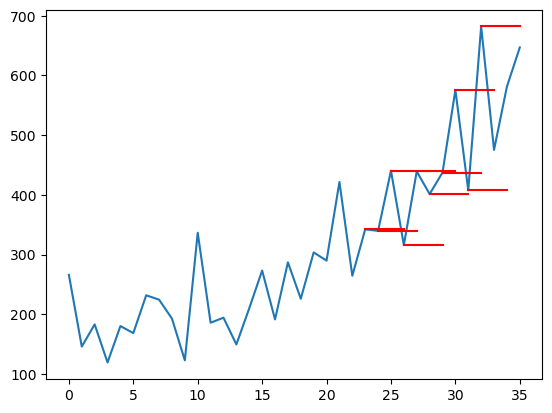

In [10]:
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)